# List 3 ex 2

## Scraper

In [41]:
import getpass
import keyring
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
import time
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from collections import deque
from csv import DictWriter, writer
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [ ]:
my_email = "olek10295@wp.pl"
keyring.set_password('facebook', 'password', getpass.getpass("Facebook password"))
path_to_chrome_driver = "chromedriver_v112"

In [25]:
linkt_to_check = deque()
linkt_to_check.append(driver.current_url[:-1])
iterations = 0
max_iterations = 10
all_peoples = []
id = 0

In [23]:
def create_save_files(people_file_name = "people.csv", friends_file_name = "friends.csv"):
    people_field_names = ['ID', 'NAME', 'LINK']
    friends_field_names = ['PERSOn 1 ID', 'PERSOn 2 ID']
    with open(people_file_name, 'w') as f_people, open(friends_file_name, 'w') as f_friends:
        people_writer = DictWriter(f_people, fieldnames=people_field_names)
        friends_writer = DictWriter(f_friends, fieldnames=friends_field_names)
        people_writer.writeheader()
        friends_writer.writeheader()
    
def create_driver(path_to_chrome_driver):
    path_to_chrome_driver = "chromedriver_v112"

    option = Options()

    option.add_argument("--disable-infobars")
    option.add_argument("start-maximized")
    option.add_argument("--disable-extensions")
    option.add_experimental_option(
        "prefs", {"profile.default_content_setting_values.notifications": 2}
    )
    driver = webdriver.Chrome(path_to_chrome_driver, chrome_options=option)
    return driver 


def sing_in_to_fb(driver):
    driver.get("https://www.facebook.com/")


    accept_cookies_button = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable(
            (By.CSS_SELECTOR, 'button[data-testid="cookie-policy-manage-dialog-accept-button"]')
        )
    )

    accept_cookies_button.click()

    user_css_selector = "input[name='email']"
    password_css_selector = "input[name='pass']"

    username_input = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, user_css_selector))
    )
    password_input = WebDriverWait(driver, 10).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, password_css_selector))
    )

    username_input.clear()
    username_input.send_keys(my_email)
    password_input.clear()
    password_input.send_keys(keyring.get_password('facebook', 'password'))
    WebDriverWait(driver, 2).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, "button[type='submit']"))
        ).click()
    
def get_my_profil(driver):
    driver.get("https://www.facebook.com/profile")
    my_fb_name = WebDriverWait(driver, 2).until(
        EC.element_to_be_clickable((By.XPATH, "//h1"))
    ).text
    return my_fb_name

def get_friend_from_link(driver, link:list[dict['name':str, 'link':str]]) -> list:
    try:
        driver.get(link)
        loading_mutual_friends_panel_xpath = "//div[contains(@data-pagelet,'ProfileAppSection')]"

        loading_element = driver.find_elements(By.XPATH, loading_mutual_friends_panel_xpath)
        loading_element = driver.find_elements(By.XPATH,
                "//div[contains(@data-pagelet, 'ProfileAppSection')]"
                )

        while len(loading_element) == 1:
            driver.find_element(By.XPATH, '//body').send_keys(Keys.END)
            time.sleep(np.random.exponential(1))
            loading_element = driver.find_elements(By.XPATH,
                loading_mutual_friends_panel_xpath
                )
        friends_panel_xpath = "//div[@data-pagelet='ProfileAppSection_0']"

        friends_pannel = driver.find_element(By.XPATH,
            friends_panel_xpath
        )

        friend_links = friends_pannel.find_elements(By.XPATH,
        "//div[@data-pagelet='ProfileAppSection_0']//a[contains(@href, '://www.facebook.')][@tabindex='0'][not(contains(@href,'friends'))]"
        )

        friends = [{"name": link.text, "link":link.get_attribute("href")} for link in friend_links]
        return friends
    except:
        return None

In [ ]:
create_save_files()

In [16]:
driver = create_driver(path_to_chrome_driver)

/tmp/ipykernel_40174/717499015.py:12: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome(path_to_chrome_driver, chrome_options=option)
/tmp/ipykernel_40174/717499015.py:12: DeprecationWarning: use options instead of chrome_options
  driver = webdriver.Chrome(path_to_chrome_driver, chrome_options=option)


In [17]:
sing_in_to_fb(driver)

In [19]:
my_fb_name = get_my_profil(driver)

In [26]:
with open('people.csv', 'a') as f_people, open('friends.csv', 'a') as f_friends:
    people_writer = writer(f_people)
    friends_writer = writer(f_friends)
    # people_writer.writerow([str(id), my_fb_name, driver.current_url[:-1]])
    # id+=1
    while iterations < max_iterations:
    
        link = linkt_to_check.popleft()
        link_to_friends = link + "/friends"
        friends_list = get_friend_from_link(driver, link_to_friends)
        if friends_list is None:
            continue
        for friend in friends_list:
            friend_link = friend["link"]
            friends_writer.writerow([link, friend_link])
            if friend not in all_peoples:
                all_peoples.append(friend)
                linkt_to_check.append(friend_link)
                people_writer.writerow([str(id), friend["name"], friend_link])
                id+=1
        iterations+=1
driver.quit()

In [32]:
people_df = pd.read_csv("people.csv")
friends_df = pd.read_csv("friends.csv")

In [33]:
edges_df = friends_df.applymap(lambda x : people_df[people_df["LINK"] == x].first_valid_index())
edges_df.head()
edges_df.to_csv("edges_index.csv")

## Tasks

### a) Save the results into a file. From know on work with the local copy of the network instead of sampling it every time.

### b)  Determine the number of nodes and edges in the network.

#### For smal graph

In [35]:
g = nx.from_pandas_edgelist(edges_df, "PERSOn 1 ID", "PERSOn 2 ID")

#### Other case use python

### c) Find celebrities in the network (hint: degree centrality).

In [37]:
sort_degree_centrality = sorted(nx.degree_centrality(g).items(), key=lambda x:x[1], reverse=True)
sort_degree_centrality

[(3, 0.17090198268640044),
 (7, 0.1482826026249651),
 (6, 0.1365540351857023),
 (11, 0.12789723540910358),
 (0, 0.10723261658754538),
 (527, 0.10471935213627477),
 (2, 0.10080982965652052),
 (5, 0.08154146886344596),
 (1, 0.06031834683049427),
 (9, 0.03602345713487852),
 (16, 0.001954761239877129),
 (73, 0.001954761239877129),
 (130, 0.001954761239877129),
 (191, 0.001954761239877129),
 (19, 0.0016755096341803965),
 (27, 0.0016755096341803965),
 (28, 0.0016755096341803965),
 (38, 0.0016755096341803965),
 (39, 0.0016755096341803965),
 (52, 0.0016755096341803965),
 (113, 0.0016755096341803965),
 (256, 0.0016755096341803965),
 (260, 0.0016755096341803965),
 (275, 0.0016755096341803965),
 (333, 0.0016755096341803965),
 (380, 0.0016755096341803965),
 (22, 0.0013962580284836636),
 (25, 0.0013962580284836636),
 (40, 0.0013962580284836636),
 (51, 0.0013962580284836636),
 (60, 0.0013962580284836636),
 (81, 0.0013962580284836636),
 (179, 0.0013962580284836636),
 (218, 0.0013962580284836636),
 (2

### d) Check the data for friend paradox.

In [38]:
degree = g.degree()
np.mean([degree[node] < np.mean([degree[neighbor] for neighbor in  g.neighbors(node)]) for node in g.nodes]) #aprox1

0.9972082635399219

### e) Plot the degree distribution of the network

In [43]:
degree_list = [d for n, d in g.degree()]
degree_sequence = sorted(degree_list, reverse=True)

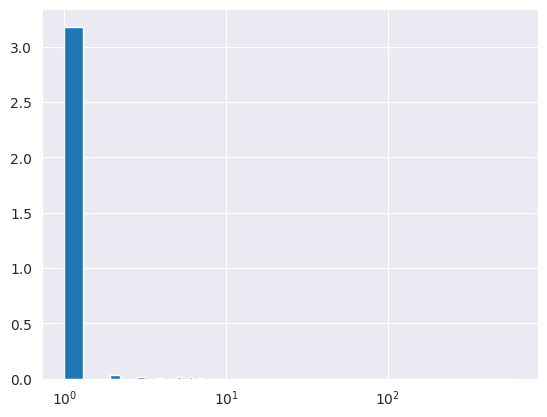

In [48]:
plt.hist(degree_sequence, density= True, bins= 2000)
plt.xscale("log")
plt.show()

### f) Find communication bottlenecks (hint: betweenness centrality)

In [49]:
sort_betweenness_centrality = sorted(nx.betweenness_centrality(g).items(), key=lambda x:x[1], reverse=True)
sort_betweenness_centrality

[(527, 0.523353718192384),
 (3, 0.29287855685719616),
 (7, 0.26937366516952443),
 (6, 0.2307645218058575),
 (11, 0.22700688618613413),
 (0, 0.18342098574559654),
 (2, 0.1804227181058213),
 (5, 0.1338722222699737),
 (1, 0.11438832197866144),
 (9, 0.06806516078808236),
 (360, 0.008615614064920538),
 (16, 0.004864050018909477),
 (73, 0.004864050018909477),
 (130, 0.004864050018909477),
 (191, 0.004864050018909477),
 (380, 0.004864050018909477),
 (275, 0.003843941856980417),
 (333, 0.003843941856980417),
 (27, 0.0027679849497351484),
 (40, 0.0027679849497351484),
 (513, 0.0027679849497351484),
 (555, 0.0027679849497351484),
 (658, 0.0027679849497351484),
 (19, 0.0020960650691742543),
 (28, 0.0020960650691742543),
 (38, 0.0020960650691742543),
 (39, 0.0020960650691742543),
 (52, 0.0020960650691742543),
 (113, 0.0020960650691742543),
 (218, 0.0020960650691742543),
 (256, 0.0020960650691742543),
 (260, 0.0020960650691742543),
 (375, 0.0020960650691742543),
 (456, 0.0020960650691742543),
 (521

### g) Visualize the network.

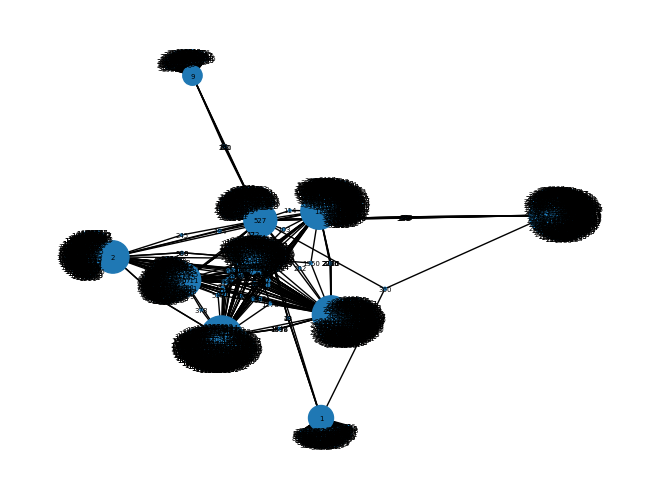

In [50]:
nx.draw(g, with_labels = True, node_size=[v * 1.5 for v in dict(g.degree()).values()], font_size = 5)